In [2]:
import pandas as pd 
import numpy as np
from numpy import cov
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import statsmodels.api as sm
import sklearn
from sklearn import preprocessing as ppr
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from sklearn.svm import SVR
import seaborn as sn

# Premise: we work for Angel Brothers Holding Corp and we want to predict
# how likely it is that our company will win a bid. 

# Potential issues:
# 1. There are very few wins (103) versus losses (2992) so it may be difficult to get an accurate test.
#    May want to consider using boosting to resample the data and create more data.

# Steps:
# 1. EDA. Check out the data and see what we're working with. How many rows? Spread of winners?
#    Correlated variables? Reduce data table to just factors of interest. 
# 2. Add some data to our table: a column for 1 = Angel Bros won the bid, 0 = Angel Bros didn't win.
# 3. Split the data into training, validate, test. Test will be unused until the very end when we have 
#    a model we're satisfied with. 
# 4. Use k-fold cross validation to create the best logistic regression model.
# 5. Check out some basic logistic regression models and use best subset selection to choose factors. 
# 6. Consider using other techniques like random forest.

# TODO:
# 1. Drop rows with 0 in the time column.

In [4]:
# read in the data and check out the data types.
texas = pd.read_csv('texas-bids.csv')
texas = texas.replace(r'\n','', regex=True) # strip out potential newline characters
texas.dtypes

proj_ID           object
seq_no             int64
time              object
estimate         float64
let_date          object
length           float64
winner            object
win_amt          float64
num_bids           int64
bid_spread       float64
compiled_bids     object
county            object
month              int64
dtype: object

In [4]:
texas.shape

(3095, 13)

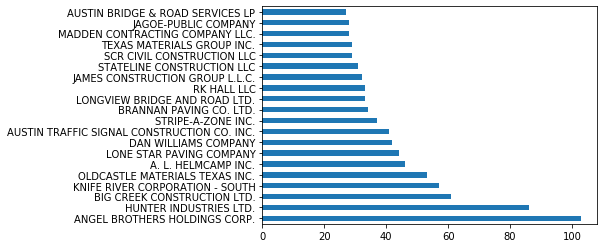

In [5]:
# Get a sense of how many we've won compared to the other top 20 winners.
texas['winner'].value_counts()[:20].plot(kind='barh')

In [6]:
# we've only won 103 out of 3095 contracts.
texas['winner'].describe()

count                              3095
unique                              381
top       ANGEL BROTHERS HOLDINGS CORP.
freq                                103
Name: winner, dtype: object

In [7]:
# we might be interested in looking at county information later.
texas['county'].describe()

count       3095
unique       244
top       HARRIS
freq         122
Name: county, dtype: object

In [7]:
texas['win_amt'].describe()

count    3.095000e+03
mean     6.277997e+06
std      1.897694e+07
min      5.673000e+03
25%      7.139577e+05
50%      1.745583e+06
75%      4.898914e+06
max      4.476150e+08
Name: win_amt, dtype: float64

In [8]:
texas['time'].describe()

count                  3095
unique                  641
top       365 CALENDAR DAYS
freq                    158
Name: time, dtype: object

In [9]:
# let's add a column to indicate if we were awarded the contract or not.
# also add a column for Harris County y/n since that's the biggest county and it might be interesting.

texas['awarded'] = (texas['winner']=='ANGEL BROTHERS HOLDINGS CORP.')*1
texas['Harris'] = (texas['county']=='HARRIS')*1

In [11]:
texas.head(10)

,proj_ID,seq_no,time,estimate,let_date,length,winner,win_amt,num_bids,bid_spread,compiled_bids,county,month,awarded,Harris
0,NH 1602(247),3001,1000 WORKING DAYS,85290427.93,2016-12-01,0.390,WILLIAMS BROTHERS CONSTRUCTION CO. INC.,73929401.69,7,13677444.11,"PULICE CONSTRUCTION INC. | $83,702,317.31; THE...",BEXAR,12,0,0
1,NH 2017(364),3005,70 WORKING DAYS,9271227.00,2016-12-01,245.978,LIPHAM ASPHALT AND PAVING COMPANY LLC,8458527.23,4,980483.12,"NORTHEASTERN PAVERS INC. | $8,685,268.42; MISS...",CALLAHAN,12,0,0
2,STP 2017(304),3007,50 WORKING DAYS,1897861.90,2016-12-01,24.044,COX PAVING OF TEXAS INC.,1878411.95,3,175059.81,"ANGEL BROTHERS HOLDINGS CORP. | $1,943,102.50;...",SAN PATRICIO,12,0,0
3,STP 2017(336)HESG,3008,90 WORKING DAYS,926589.24,2016-12-01,84.957,STRIPE-A-ZONE INC.,814705.32,4,369169.29,"STRIPING TECHNOLOGY L.P. | $978,681.96; TRP CO...",HARRISON,12,0,0
4,NH 2017(152),3009,159 WORKING DAYS,8480601.48,2016-12-01,4.276,ANGEL BROTHERS HOLDINGS CORP.,6295132.13,4,753615.94,"HUNTER INDUSTRIES LTD. | $6,750,845.50; CLARK ...",COMAL,12,1,0
5,NH 2017(352),3010,65 WORKING DAYS,8432162.25,2016-12-01,230.447,BRANNAN PAVING CO. LTD.,8807758.17,2,407097.19,"BRANNAN PAVING CO. LTD. | $8,807,758.17; MISSO...",HUNT,12,0,0
6,STP 2017(319)HES,3011,45 WORKING DAYS,353138.40,2016-12-01,0.002,TRAF-TEX INC.,306857.45,3,78342.16,"THIRD COAST SERVICES LLC | $339,457.52; STATEW...",MATAGORDA,12,0,0
7,NH 2017(399),3012,51 WORKING DAYS,4023873.06,2016-12-01,7.628,ZACK BURKETT CO.,3440613.52,4,2132726.68,"AUSTIN BRIDGE & ROAD SERVICES LP | $3,636,072....",WICHITA,12,0,0
8,STP 2017(370)HES,3013,32 WORKING DAYS,142466.76,2016-12-01,0.100,OPPORTUNITY EXCAVATION/CONCRETE LLC,171970.75,3,283966.77,"J. LEE MILLIGAN INC. | $230,939.50; RK HALL LL...",DICKENS,12,0,0
9,STP 2017(333)HES,3015,203 WORKING DAYS,652636.48,2016-12-01,0.009,TEXAS TRAFFIC CONTROL SYSTEMS INC.,566437.35,4,136744.68,"STRIPING TECHNOLOGY L.P. | $570,658.95; DURABL...",BOWIE,12,0,0


In [10]:
texas['awarded'].value_counts()

0    2992
1     103
Name: awarded, dtype: int64

In [11]:
texas['Harris'].value_counts()

0    2973
1     122
Name: Harris, dtype: int64

In [12]:
# Create a smaller version of the table
texas = texas[['proj_ID', 'seq_no', 'time', 'estimate', 'length', 'num_bids', 'county', 'month', 'awarded', 'Harris']]
texas.head(5)

,proj_ID,seq_no,time,estimate,length,num_bids,county,month,awarded,Harris
0,NH 1602(247),3001,1000 WORKING DAYS,85290427.93,0.390,7,BEXAR,12,0,0
1,NH 2017(364),3005,70 WORKING DAYS,9271227.00,245.978,4,CALLAHAN,12,0,0
2,STP 2017(304),3007,50 WORKING DAYS,1897861.90,24.044,3,SAN PATRICIO,12,0,0
3,STP 2017(336)HESG,3008,90 WORKING DAYS,926589.24,84.957,4,HARRISON,12,0,0
4,NH 2017(152),3009,159 WORKING DAYS,8480601.48,4.276,4,COMAL,12,1,0


In [13]:
# Get just the numeric data out of the time column.
# For the sake of ease we'll consider working days and calendar days to be equal timeframes.
# In a real world scenario we'd want to equalize these, e.g. convert calendar days to working days.

tex = texas.copy()
tex['time'] = tex['time'].str.extract('(\d+)').astype(float)
tex.head(10)

,proj_ID,seq_no,time,estimate,length,num_bids,county,month,awarded,Harris
0,NH 1602(247),3001,1000.0,85290427.93,0.390,7,BEXAR,12,0,0
1,NH 2017(364),3005,70.0,9271227.00,245.978,4,CALLAHAN,12,0,0
2,STP 2017(304),3007,50.0,1897861.90,24.044,3,SAN PATRICIO,12,0,0
3,STP 2017(336)HESG,3008,90.0,926589.24,84.957,4,HARRISON,12,0,0
4,NH 2017(152),3009,159.0,8480601.48,4.276,4,COMAL,12,1,0
5,NH 2017(352),3010,65.0,8432162.25,230.447,2,HUNT,12,0,0
6,STP 2017(319)HES,3011,45.0,353138.40,0.002,3,MATAGORDA,12,0,0
7,NH 2017(399),3012,51.0,4023873.06,7.628,4,WICHITA,12,0,0
8,STP 2017(370)HES,3013,32.0,142466.76,0.100,3,DICKENS,12,0,0
9,STP 2017(333)HES,3015,203.0,652636.48,0.009,4,BOWIE,12,0,0


In [14]:
# check to make sure each value in the time column is a float.
tex['time'].apply(type).value_counts()

<class 'float'>    3095
Name: time, dtype: int64

In [15]:
# some of these are zero. We should consider dropping rows with 0 in the time column.
tex['time'].describe()

count    3095.000000
mean      178.044911
std       181.606096
min         0.000000
25%        61.500000
50%       119.000000
75%       234.000000
max      2030.000000
Name: time, dtype: float64

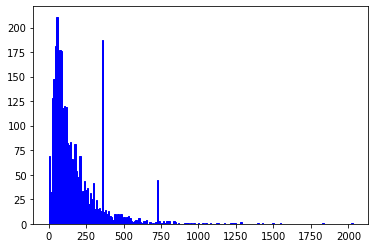

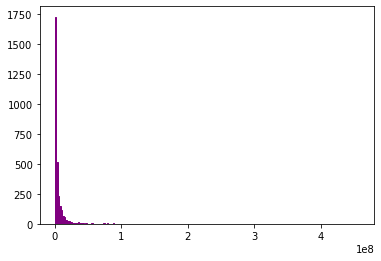

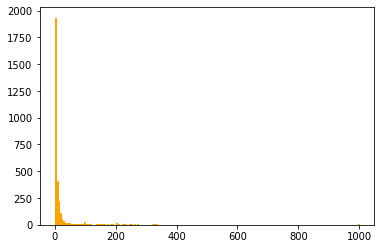

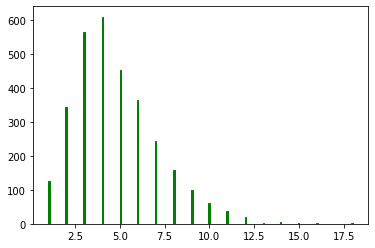

In [16]:
# Now let's do some plotting. First, check that our numerical data is sufficiently normal.

a = plt.hist(tex['time'], color = 'blue', edgecolor = 'blue',
         bins = 200)
plt.show(a)
# time might need to be transformed

b = plt.hist(tex['estimate'], color = 'purple', edgecolor = 'purple',
         bins = 200)
plt.show(b)
# estimate definitely needs to be transformed

c = plt.hist(tex['length'], color = 'orange', edgecolor = 'orange',
         bins = 200)
plt.show(c)
# length definitely needs to be transformed

d = plt.hist(tex['num_bids'], color = 'green', edgecolor = 'green',
         bins = 200)
plt.show(d)
# num bids looks good

In [17]:
# standardize the data
scaler = ppr.StandardScaler()
scaled = pd.DataFrame(scaler.fit_transform(tex[['time', 'estimate', 'length']]))
scaled.columns = ['time', 'estimate', 'length']
scaled.head(5)

,time,estimate,length
0,4.526764,4.153070,-0.286737
1,-0.595037,0.150534,2.943656
2,-0.705183,-0.237686,0.024401
3,-0.484891,-0.288825,0.825633
4,-0.104886,0.108906,-0.235621


In [18]:
# outer join the scaled data frame with the non-scaled columns
tex_non = tex[['proj_ID', 'seq_no', 'num_bids', 'county', 'month', 'awarded', 'Harris']] # non-scaled columns
tex_std = pd.concat([tex_non, scaled], axis=1, sort=False)
tex_std.head(5)

,proj_ID,seq_no,num_bids,county,month,awarded,Harris,time,estimate,length
0,NH 1602(247),3001,7,BEXAR,12,0,0,4.526764,4.153070,-0.286737
1,NH 2017(364),3005,4,CALLAHAN,12,0,0,-0.595037,0.150534,2.943656
2,STP 2017(304),3007,3,SAN PATRICIO,12,0,0,-0.705183,-0.237686,0.024401
3,STP 2017(336)HESG,3008,4,HARRISON,12,0,0,-0.484891,-0.288825,0.825633
4,NH 2017(152),3009,4,COMAL,12,1,0,-0.104886,0.108906,-0.235621


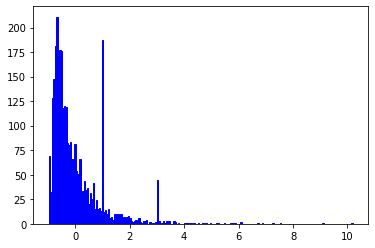

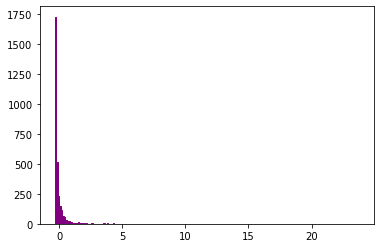

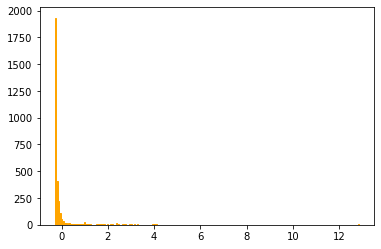

In [19]:
# plot again. These are definitely not perfect, but in the interest of time I'm going to 
# move forward and look up solutions for normalizing the data later.
a = plt.hist(tex_std['time'], color = 'blue', edgecolor = 'blue',
         bins = 200)
plt.show(a)

b = plt.hist(tex_std['estimate'], color = 'purple', edgecolor = 'purple',
         bins = 200)
plt.show(b)

c = plt.hist(tex_std['length'], color = 'orange', edgecolor = 'orange',
         bins = 200)
plt.show(c)

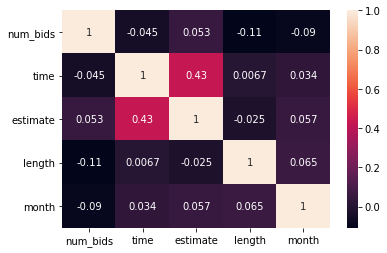

In [20]:
# get the correlation matrix.
corrMatrix = tex_std[['num_bids', 'time', 'estimate', 'length', 'month']].corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [21]:
# looks like time and estimate are closely correlated. Let's throw out time since it's not the
# most accurate anyway (given some values were in calendar days and some in working days).
tex_std = tex_std.drop('time', axis=1)

# may as well drop some of the other columns that don't look to be useful.
tex_std = tex_std.drop(['proj_ID', 'seq_no', 'county'], axis=1)
tex_std.head(10)

,num_bids,month,awarded,Harris,estimate,length
0,7,12,0,0,4.153070,-0.286737
1,4,12,0,0,0.150534,2.943656
2,3,12,0,0,-0.237686,0.024401
3,4,12,0,0,-0.288825,0.825633
4,4,12,1,0,0.108906,-0.235621
5,2,12,0,0,0.106356,2.739366
6,3,12,0,0,-0.319018,-0.291840
7,4,12,0,0,-0.125748,-0.191530
8,3,12,0,0,-0.330110,-0.290551
9,4,12,0,0,-0.303249,-0.291748


In [24]:
# We may finally be ready to try some modeling! Split the data into train and test.
# We're going to be trying a few different methods for splitting the data, hence the "2" suffix.
y = tex_std['awarded']
X_train2, X_test2, y_train2, y_test2 = train_test_split(tex_std.drop('awarded',axis=1), y, test_size=0.4, random_state=5)
print(X_train2.shape, y_train2.shape)
print(X_test2.shape, y_test2.shape)

(1857, 5) (1857,)
(1238, 5) (1238,)


In [25]:
# let's try some logistic regression before trying cross-validation because I'm eager to see some potential results
logmodel = sm.Logit(y_train2, X_train2)
result = logmodel.fit(maxiter=60)
#y_pred = result.predict(X_test)

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.152976
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                awarded   No. Observations:                 1857
Model:                          Logit   Df Residuals:                     1852
Method:                           MLE   Df Model:                            4
Date:                Mon, 13 Apr 2020   Pseudo R-squ.:                 -0.1467
Time:                        08:50:24   Log-Likelihood:                -284.08
converged:                       True   LL-Null:                       -247.74
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
num_bids      -0.4127      0.044     -9.337      0.000      -0.499      -0.326
month         -0.2989      0.

In [26]:
# Looks like Harris  and length aren't doing much for us so let's drop them.
tex_std = tex_std.drop(['Harris', 'length'], axis=1)
tex_std.head(10)

,num_bids,month,awarded,estimate
0,7,12,0,4.153070
1,4,12,0,0.150534
2,3,12,0,-0.237686
3,4,12,0,-0.288825
4,4,12,1,0.108906
5,2,12,0,0.106356
6,3,12,0,-0.319018
7,4,12,0,-0.125748
8,3,12,0,-0.330110
9,4,12,0,-0.303249


In [27]:
# create a new regression model without Harris and length.
y = tex_std['awarded']
X = tex_std.drop('awarded',axis=1)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.4, random_state=5)
print(X_train1.shape, y_train1.shape)
print(X_test1.shape, y_test1.shape)
logmodel = sm.Logit(y_train1, X_train1)
result = logmodel.fit(maxiter=60)
y_pred1 = result.predict(X_test1)

print(result.summary())
# cool, looks like removing Harris and length had a good impact on the p-value for estimate.

(1857, 3) (1857,)
(1238, 3) (1238,)
Optimization terminated successfully.
         Current function value: 0.153887
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                awarded   No. Observations:                 1857
Model:                          Logit   Df Residuals:                     1854
Method:                           MLE   Df Model:                            2
Date:                Mon, 13 Apr 2020   Pseudo R-squ.:                 -0.1535
Time:                        08:51:04   Log-Likelihood:                -285.77
converged:                       True   LL-Null:                       -247.74
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
num_bids      -0.4021      0.043     -9.315      0.000      -0.487      

In [28]:
cnf_matrix=result.pred_table()

Text(0.5, 257.44, 'Predicted label')

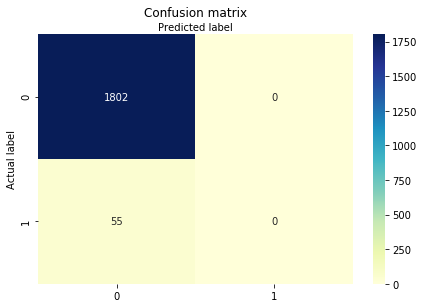

In [29]:
# make a nice-looking confusion matrix
%matplotlib inline
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sn.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Area under the ROC curve : 0.525035


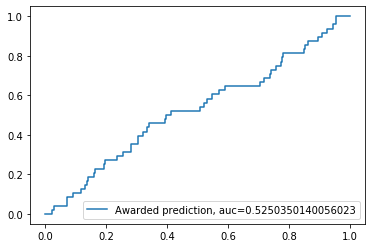

In [30]:
# create an ROC curve
fpr, tpr, thresholds = roc_curve(y_test1, y_pred1)
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)
# Plot 
plt.plot(fpr,tpr,label="Awarded prediction, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

In [32]:
# The ROC curve above looks pretty bad. Our data has so few awarded contracts compared to not awarded, so the model
# is just predicting that we're never awarded a contract. The problem is that it still gets really high accuracy by 
# predicting everything will be 0.
# What can we do to resolve this?
# 1. Look up methods for data spread like this
# 2. Try with a different train/test split, or try boosting
# 3. Start again k-fold cross validation
# 4. Consider predictions above a certain threshold to be "1" rather than "0"

# Now use k-fold cross validation with SVRs
scores = []
best_svr = SVR(kernel='rbf')
kf = KFold(10, shuffle=False)
for train_index, test_index in kf.split(X):
    print("Train Index: ", train_index)
    print("Test Index: ", test_index)

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test =  y[train_index], y[test_index]
    best_svr.fit(X_train, y_train)
    scores.append(best_svr.score(X_test, y_test))
    
# I'm getting an error here I've already taken too long to try and fix. It doesn't seem
# to cause any issues further down the line, but in the real world we'd need to diagnose this.
# It probably has something to do with the fact that I don't 100% understand SVRs yet!

Train Index:  [ 310  311  312 ... 3092 3093 3094]
Test Index:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 

KeyError: "None of [Int64Index([ 310,  311,  312,  313,  314,  315,  316,  317,  318,  319,\n            ...\n            3085, 3086, 3087, 3088, 3089, 3090, 3091, 3092, 3093, 3094],\n           dtype='int64', length=2785)] are in the [columns]"

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   2.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,
          1.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,
          1.,   1.,   0.,   2.,   0.,   1.,   0.,   2.,   0.,   1.,   2.,
          0.,   1.,   0.,   1.,   1.,   1.,   0.,   1.,   1.,   1.,   2.,
          0.,   0.,   1.,   0.,   0.,   0.,   2.,   0.,   1.,   2.,   7.,
          2.,   3.,   3.,   2.,   1.,   3.,   2.,   3.,  11.,   7.,  14.,
          4.,   8.,  20., 100., 305., 517., 967., 694., 340.,  33.,   1.,
          4.,   0.,   2.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

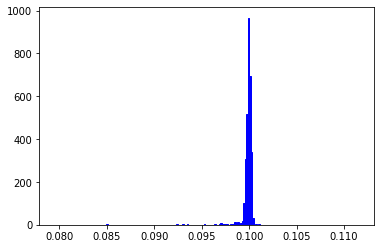

In [36]:
# Get the predicted values.
y_preds = cross_val_predict(best_svr, X, y, cv=10)
plt.hist(y_preds, color = 'blue', edgecolor = 'blue',
         bins = 200)
# This suggests that we should consider any prediction over 0.11 to be a 1
# What would our confusion matrix and ROC curve look like if we did that?

In [42]:
# At this point I've run out of time! I didn't follow the originally-outlined steps exactly, but that's ok.
# We did a lot of analysis and got to know the data pretty well.

# Next steps could include:
# 1. Do some more data cleaning and EDA. I was reminded toward the end that the time column has some zeroes.
#    There may be issues with other columns, too.
# 2. Classify predictions over 0.11 as 1 and create a new confusion matrix and ROC curve to compare the
#    false positive rate with the true positive rate.
# 3. Try boosting. There's not a ton of data so it's really hard for the logistic regression to detect an
#    awarded contract. Are there other techniques we could use to increase the precision?
# 4. Try other tools, like random forest. Compare the output.
# 5. Check out other questions: 
#    a. Can we predict the winning bid amount? That would be really useful – a company 
#    could use length, estimate, county, or whatever factors end up being relevant to not overbid.
#    b. Is there a relationship between who bid and who wins? Check out the compiled bids column. I wonder if 
#    certain companies are favored over others due to reputation, bribery, etc. Maybe a company wouldn't even
#    try for a bid if they knew Company A was already bidding. 
#    c. What about predicting the winner? Among the 381 companies, can we predict who is likely to win a given 
#    contract? Again, there would be an issue with not enough data, so you'd probably have to reduce the number
#    of categories to 5 or fewer, e.g. companies with <1000 employees in one group, companies with >1000 in another.
#    Would have to think through the bias introduced by splitting in that way. 